In [4]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
df = pd.read_excel('adjusted_dataset.xlsx')
obesity_data = df.sample(frac=1, random_state=42).reset_index(drop=True)
X = obesity_data[['Sex', 'Age', 'Height', 'Overweight_Obese_Family', 'Consumption_of_Fast_Food', 'Frequency_of_Consuming_Vegetables', 'Number_of_Main_Meals_Daily', 'Food_Intake_Between_Meals', 'Smoking', 'Liquid_Intake_Daily', 'Calculation_of_Calorie_Intake', 'Physical_Excercise', 'Schedule_Dedicated_to_Technology', 'Type_of_Transportation_Used']]
y = obesity_data['Class']
# Convert all boolean columns in X to 0/1
#X = X.apply(lambda col: col.astype(int) if col.dtype == bool else col)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == bool else col)
#print(X.dtypes)
#print(y.dtype)
#print(X.head())

In [6]:
# Convert X and y to PyTensor variables
X_tensor = pt.as_tensor_variable(X.values)
y_tensor = pt.as_tensor_variable(y.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


c:\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.


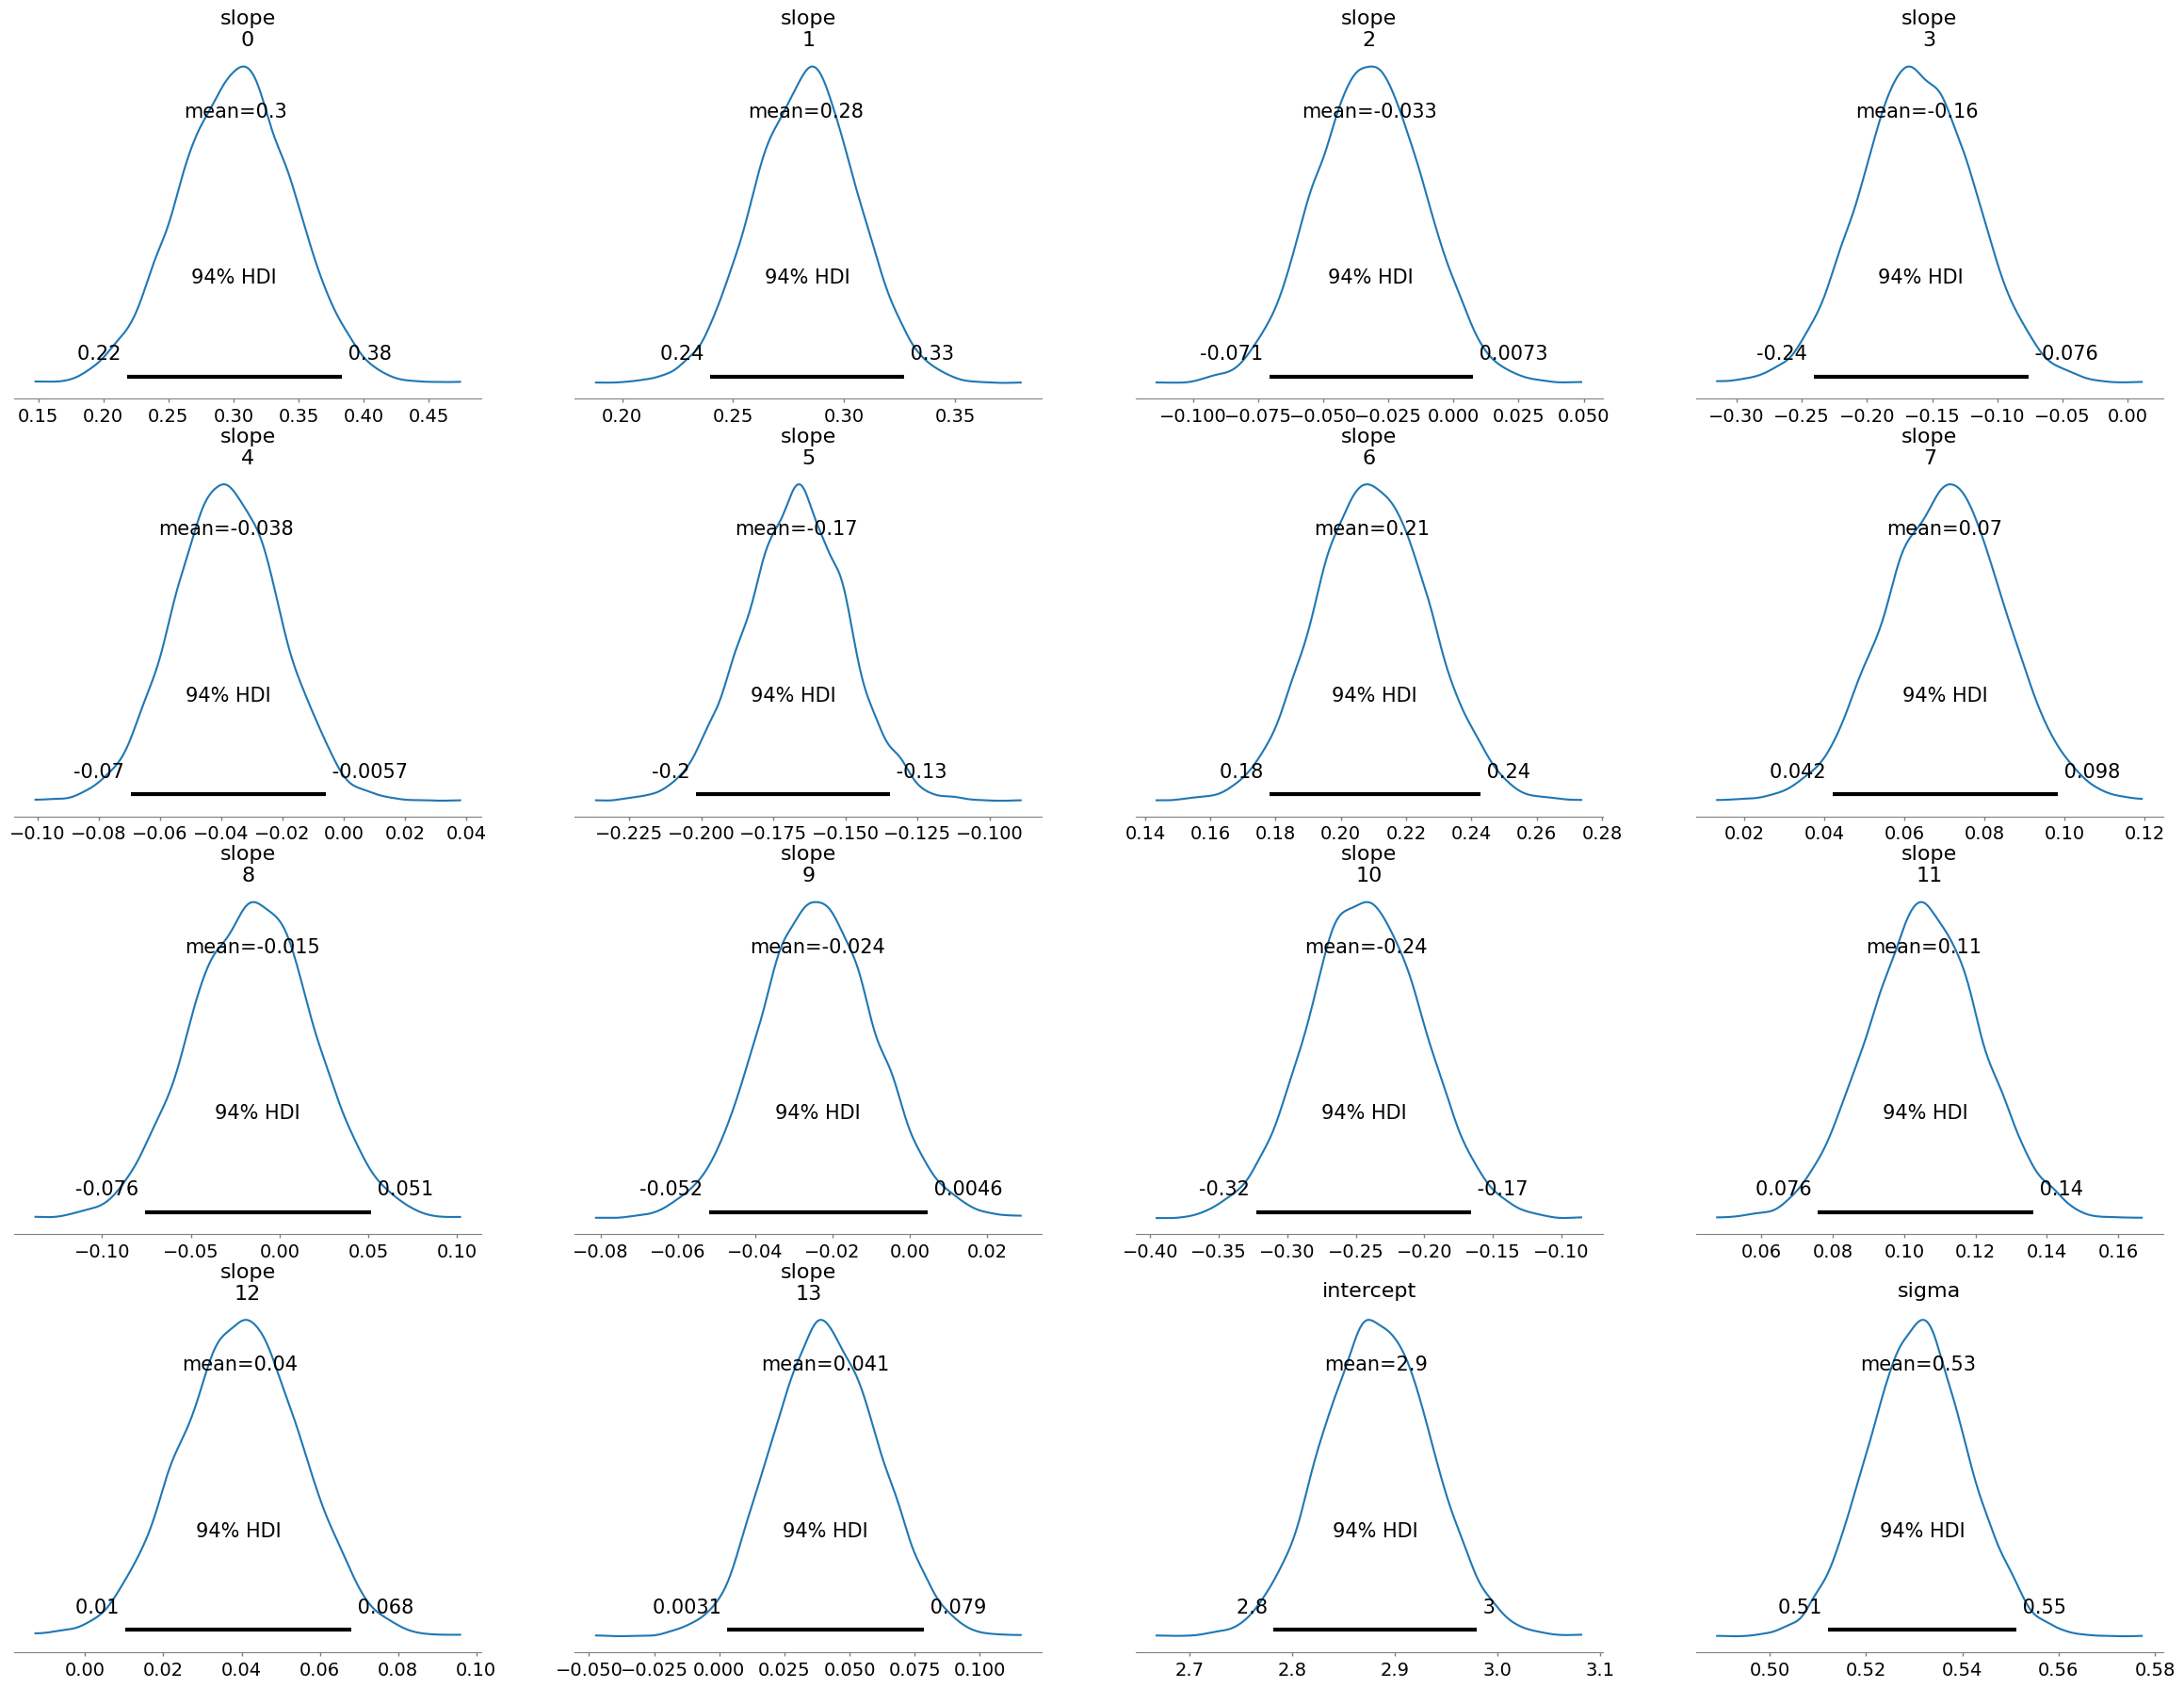

In [ ]:
# Define model
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sigma=10) #posterior = likelihood times prior 
    slope = pm.Normal('slope', mu=0, sigma=10, shape=X_train.shape[1]) #
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of the outcome (linear combination of features)
    mu = intercept + pt.dot(X_train, slope)
    
    # Likelihood (sampling distribution) of the observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)
    
    # Run the MCMC sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95)

# Plot the posterior distributions
pm.plot_posterior(trace, var_names=['slope', 'intercept', 'sigma'])
plt.show()

In [8]:
#print(trace)
#print(trace.posterior)
#print(trace.posterior.keys())

In [9]:
intercept_samples = trace.posterior['intercept'].values
slope_samples = trace.posterior['slope'].values
# Flatten across chains and draws
intercept_samples = intercept_samples.flatten()
slope_samples = slope_samples.reshape(-1, slope_samples.shape[-1])

In [10]:
# Step 1: Extract posterior samples
intercept_samples = trace.posterior['intercept'].values.flatten()  # Shape: (8000,)
slope_samples = trace.posterior['slope'].values.reshape(-1, slope_samples.shape[-1])  # Shape: (8000, 14)

# Step 2: Calculate posterior predictive mean (mu) for X_test
intercept_samples = intercept_samples[None, :]  # Reshape to (1, 8000) for broadcasting
mu_samples = intercept_samples + np.dot(X_test, slope_samples.T)  # Shape: (322, 8000)

# Step 3: Aggregate predictions across samples
mean_predictions = np.mean(mu_samples, axis=1)  # Shape: (322,)

# Step 4: Compute classification metrics
predicted_classes = np.round(mean_predictions)
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6988


              precision    recall  f1-score   support

           1       0.50      0.20      0.29        10
           2       0.77      0.82      0.80       125
           3       0.65      0.72      0.68       130
           4       0.66      0.47      0.55        57

    accuracy                           0.70       322
   macro avg       0.64      0.55      0.58       322
weighted avg       0.69      0.70      0.69       322

F1 Score: 0.6902


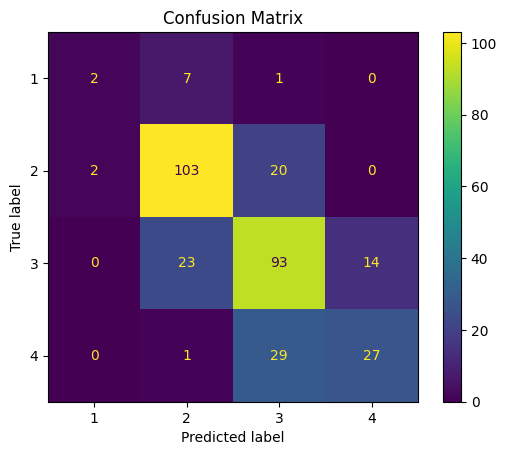

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_classes))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, predicted_classes)
plt.title("Confusion Matrix")
plt.show
from sklearn.metrics import f1_score
f1 = f1_score(y_test, predicted_classes, average='weighted')  # or 'macro'
print(f"F1 Score: {f1:.4f}")

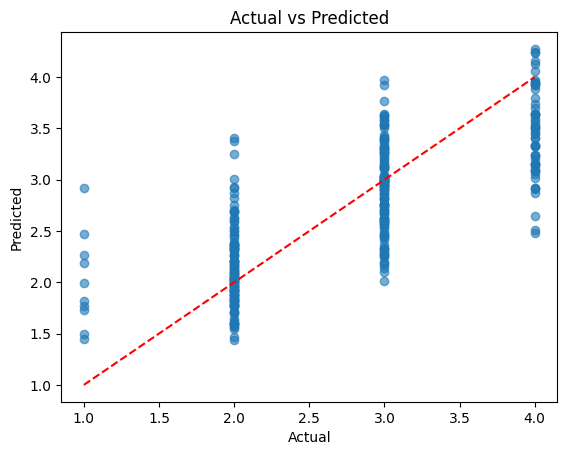

In [12]:
plt.scatter(y_test, mean_predictions, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

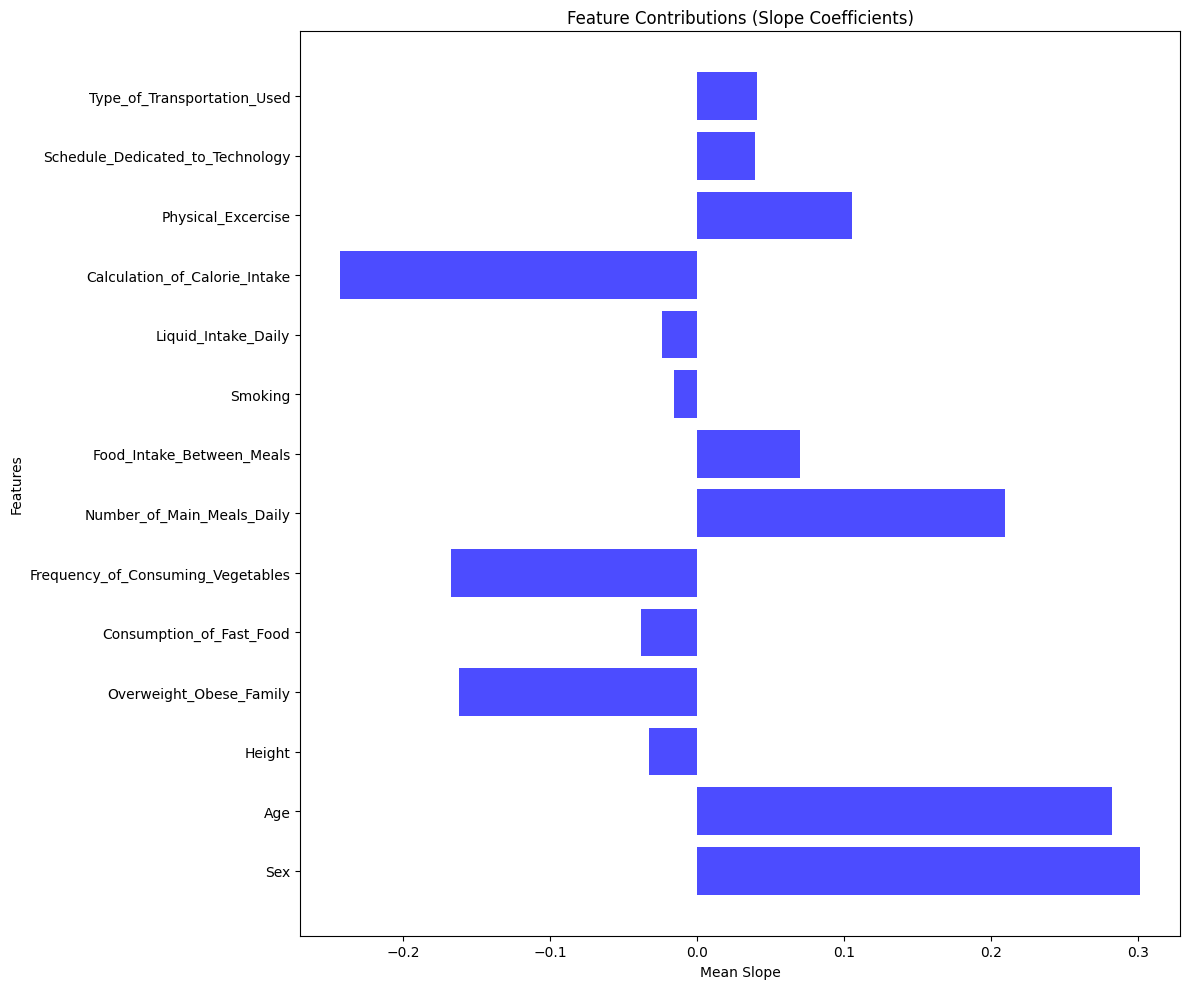

In [13]:
feature_names = X_train.columns.tolist()
feature_names = ['Sex', 'Age', 'Height', 'Overweight_Obese_Family', 'Consumption_of_Fast_Food', 'Frequency_of_Consuming_Vegetables', 'Number_of_Main_Meals_Daily', 'Food_Intake_Between_Meals', 'Smoking', 'Liquid_Intake_Daily', 'Calculation_of_Calorie_Intake', 'Physical_Excercise', 'Schedule_Dedicated_to_Technology', 'Type_of_Transportation_Used']
mean_slope = np.mean(slope_samples, axis=0)
# Plot bar chart with feature names
plt.figure(figsize=(12, 10))  # Adjust height for better spacing
plt.barh(feature_names, mean_slope, alpha=0.7, color='blue')
plt.xlabel("Mean Slope")
plt.ylabel("Features")
plt.title("Feature Contributions (Slope Coefficients)")
plt.tight_layout()
plt.show()